# Realistic lightcurves of ellipsoids

This notebook demonstrates how to generate lightcurves within `sorcha`,
under the assumption that the Solar System Objects (SSOs) are simple tri-axial ellipsoids, defined 
by 
$ a \ge b \ge c$,
in simple short-axis rotation mode.

Compared to the ``Ellipsoidal_Lightcurve`` model, the projected surface of the ellipsoid accounts for the non-illuminated part.

In [1]:
import numpy as np
import pandas as pd

import rocks
import requests

import astropy.units as u
from astropy.coordinates import SkyCoord

from sorcha.modules.PPCalculateApparentMagnitudeInFilter import (
    PPCalculateApparentMagnitudeInFilter,
)

import matplotlib.pyplot as plt

# Constants
au = 1.495978707e8  # AU in km
c = 299792458  # m/s
c_AUperDay = c * (1000 / au) * 86400.0

/home/bcarry/anaconda3/envs/sorcha/lib/python3.11/site-packages/assist/__init__.py:44: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Lightweight ephemeris function

We will need to compute ephemerides, so let's query the [Miriade](https://ssp.imcce.fr/webservices/miriade/) Virtual Observatory Web service.

In [2]:
def ephemcc(ident, ep, nbd=None, step=None, observer="500", rplane="1", tcoor=5, output=None):
    """Gets asteroid ephemerides from IMCCE Miriade for a suite of JD for a single SSO
    Original function by M. Mahlke

    :ident: int, float, str - asteroid identifier
    :ep: float, str, list - Epoch of computation
    :observer: str - IAU Obs code - default to geocenter: https://minorplanetcenter.net//iau/lists/ObsCodesF.html
    :returns: pd.DataFrame - Input dataframe with ephemerides columns appended
              False - If query failed somehow

    """

    # ------
    # Miriade URL
    url = "https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php"

    # Query parameters
    params = {
        "-name": f"{ident}",
        "-mime": "json",
        "-rplane": rplane,
        "-tcoor": tcoor,
        "-output": "--jd",
        "-observer": observer,
        "-tscale": "UTC",
    }

    if "output" in locals():
        params["-output"] += "," + output

    # Single epoch of computation
    if type(ep) != list:
        # Set parameters
        params["-ep"] = ep
        if nbd != None:
            params["-nbd"] = nbd
        if step != None:
            params["-step"] = step

        # Execute query
        try:
            r = requests.post(url, params=params, timeout=80)
        except requests.exceptions.ReadTimeout:
            return False

    # Multiple epochs of computation
    else:
        # Epochs of computation
        files = {"epochs": ("epochs", "\n".join(["%.6f" % epoch for epoch in ep]))}

        # Execute query
        try:
            r = requests.post(url, params=params, files=files, timeout=50)
        except requests.exceptions.ReadTimeout:
            return False

    j = r.json()

    # Read JSON response
    try:
        ephem = pd.DataFrame.from_dict(j["data"])
    except KeyError:
        return False

    return ephem

## Definition of simulation

We first define the epochs of the simulation: starting date (expressed in JD), the number of epochs to simulate, and time step between each (in days).

In [3]:
# Choice of time frame
jd0 = 2461041.5  # Start date: here set to 2026-01-01
nbd = 1500  # Number of epochs
step = 0.3  # Time step between epochs (days)

We then define the target. It can be an asteroid name/designation or number.
The absolute magnitude and spin properties (coordinates and period) are then retrieved from [SsODNet](https://ssp.imcce.fr/webservices/ssodnet/) (see [Berthier et al., 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...671A.151B/abstract)). Alternatively, you can define all parameters by hand:

- ``H`` the absolute magnitude
- ``ra0`` the right ascension of the spin coordinates (equatorial frame, in degrees) 
- ``dec0`` the declination of the spin coordinates (equatorial frame, in degrees) 
- ``period`` the sidereal rotation period (in hour) 
- ``G1`` and ``G2`` the phase curve coefficients
- ``a_b`` the ratio of equatorial diameters (_a_ and _b_)
- ``a_c`` the ratio between the longest (equatorial) diameter (_a_) and the polar diameter (_c_)

In [4]:
# Target
sso = 22

# Retrieve the target properties from SsODNet
sc = rocks.Rock(sso)
H = sc.H.value
ra0 = sc.spin.RA0.value
dec0 = sc.spin.DEC0.value
period = sc.spin.period.value[0] / 24.0

# Arbitrary phase function and shape
G1 = 0.62
G2 = 0.14
a_b = 1.5
a_c = 2.0

In [5]:
# Generate ephemerides
# We use here a special output from Miriade, dedicated to this kind of photometric modeling
eph = ephemcc(
    sso,
    ep=jd0,
    nbd=nbd,
    step=step,
    tcoor=5,
    observer="X05",
    output="-- iofile(ephemcc-photom.xml),--lighttime",
)

In [6]:
# Build the observations dataframe
observations_df = pd.DataFrame(
    {
        "fieldMJD_TAI": eph.Date.values,
        "H_filter": H * np.ones(nbd),
        "G1": G1 * np.ones(nbd),
        "G2": G2 * np.ones(nbd),
        "RA_deg": eph.RA.values,
        "Dec_deg": eph.DEC.values,
        "RA_s_deg": eph.RA_h.values,
        "Dec_s_deg": eph.DEC_h.values,
        "Period": period * np.ones(nbd),
        "Time0": jd0 * np.ones(nbd),
        "phi0": np.radians(0) * np.ones(nbd),
        "RA0": np.radians(ra0) * np.ones(nbd),
        "Dec0": np.radians(dec0) * np.ones(nbd),
        "Period": period * np.ones(nbd),
        "a/b": a_b * np.ones(nbd),
        "a/c": a_c * np.ones(nbd),
        "Range_LTC_km": eph.Dobs.values * au,
        "Obj_Sun_LTC_km": eph.Dhelio.values * au,
        "phase_deg": eph.Phase.values,
    }
)

observations_df

,fieldMJD_TAI,H_filter,G1,G2,RA_deg,Dec_deg,RA_s_deg,Dec_s_deg,Period,Time0,phi0,RA0,Dec0,a/b,a/c,Range_LTC_km,Obj_Sun_LTC_km,phase_deg
0,2461041.5,6.79,0.62,0.14,359.334334,-11.523769,18.478296,-3.665327,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.177865e+08,4.049300e+08,20.522908
1,2461041.8,6.79,0.62,0.14,359.407445,-11.465113,18.536963,-3.629770,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.183388e+08,4.048958e+08,20.502883
2,2461042.1,6.79,0.62,0.14,359.482166,-11.406700,18.595636,-3.594204,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.188799e+08,4.048617e+08,20.481478
3,2461042.4,6.79,0.62,0.14,359.555298,-11.348389,18.654314,-3.558628,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.194149e+08,4.048277e+08,20.461570
4,2461042.7,6.79,0.62,0.14,359.628519,-11.289645,18.712998,-3.523043,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.199635e+08,4.047937e+08,20.441432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2461490.0,6.79,0.62,0.14,100.442283,35.559274,125.440170,30.992455,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.696081e+08,4.089152e+08,21.330520
1496,2461490.3,6.79,0.62,0.14,100.514005,35.545997,125.518137,30.985766,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.702196e+08,4.089530e+08,21.336566
1497,2461490.6,6.79,0.62,0.14,100.583783,35.532027,125.596080,30.979031,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.708370e+08,4.089908e+08,21.344123
1498,2461490.9,6.79,0.62,0.14,100.656047,35.517137,125.673996,30.972250,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.714625e+08,4.090287e+08,21.349582


In [7]:
# Build the observations dataframe
observations_df = pd.DataFrame(
    {
        "fieldMJD_TAI": eph.Date.values,
        "H_filter": H * np.ones(nbd),
        "G1": G1 * np.ones(nbd),
        "G2": G2 * np.ones(nbd),
        "RA_deg": eph.RA.values,
        "Dec_deg": eph.DEC.values,
        "RA_s_deg": eph.RA_h.values,
        "Dec_s_deg": eph.DEC_h.values,
        "Period": period * np.ones(nbd),
        "Time0": jd0 * np.ones(nbd),
        "phi0": np.radians(0) * np.ones(nbd),
        "RA0": np.radians(ra0) * np.ones(nbd),
        "Dec0": np.radians(dec0) * np.ones(nbd),
        "Period": period * np.ones(nbd),
        "a/b": a_b * np.ones(nbd),
        "a/c": a_c * np.ones(nbd),
        "Range_LTC_km": eph.Dobs.values * au,
        "Obj_Sun_LTC_km": eph.Dhelio.values * au,
        "phase_deg": eph.Phase.values,
    }
)

observations_df

,fieldMJD_TAI,H_filter,G1,G2,RA_deg,Dec_deg,RA_s_deg,Dec_s_deg,Period,Time0,phi0,RA0,Dec0,a/b,a/c,Range_LTC_km,Obj_Sun_LTC_km,phase_deg
0,2461041.5,6.79,0.62,0.14,359.334334,-11.523769,18.478296,-3.665327,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.177865e+08,4.049300e+08,20.522908
1,2461041.8,6.79,0.62,0.14,359.407445,-11.465113,18.536963,-3.629770,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.183388e+08,4.048958e+08,20.502883
2,2461042.1,6.79,0.62,0.14,359.482166,-11.406700,18.595636,-3.594204,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.188799e+08,4.048617e+08,20.481478
3,2461042.4,6.79,0.62,0.14,359.555298,-11.348389,18.654314,-3.558628,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.194149e+08,4.048277e+08,20.461570
4,2461042.7,6.79,0.62,0.14,359.628519,-11.289645,18.712998,-3.523043,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.199635e+08,4.047937e+08,20.441432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2461490.0,6.79,0.62,0.14,100.442283,35.559274,125.440170,30.992455,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.696081e+08,4.089152e+08,21.330520
1496,2461490.3,6.79,0.62,0.14,100.514005,35.545997,125.518137,30.985766,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.702196e+08,4.089530e+08,21.336566
1497,2461490.6,6.79,0.62,0.14,100.583783,35.532027,125.596080,30.979031,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.708370e+08,4.089908e+08,21.344123
1498,2461490.9,6.79,0.62,0.14,100.656047,35.517137,125.673996,30.972250,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.714625e+08,4.090287e+08,21.349582


## SORCHA simulation

We first simply compute the apparent magnitude, using the
$H G_1 G_2$ formalism, as a baseline.

In [8]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "HG1G2", "r", "HG1G2_mag")

We then load the lightcurve methods of ``SORCHA`` add-ons:

In [9]:
from sorcha.lightcurves.lightcurve_registration import LC_METHODS, update_lc_subclasses

update_lc_subclasses()
print("Lightcurve methods: " + ", ".join(LC_METHODS))

Lightcurve methods: identity, sinusoidal, ellipsoidal, ellipsoidalwithterminator


We can now compute the apparent magnitude **with** the lightcurve effect (using the
$H G_1 G_2$ formalism for consistency).

In [10]:
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG1G2", "r", "LC_HG1G2_mag", "ellipsoidal"
)

observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG1G2", "r", "LCwT_HG1G2_mag", "ellipsoidalwithterminator"
)

## Graphics illustrating the lightcurve effect

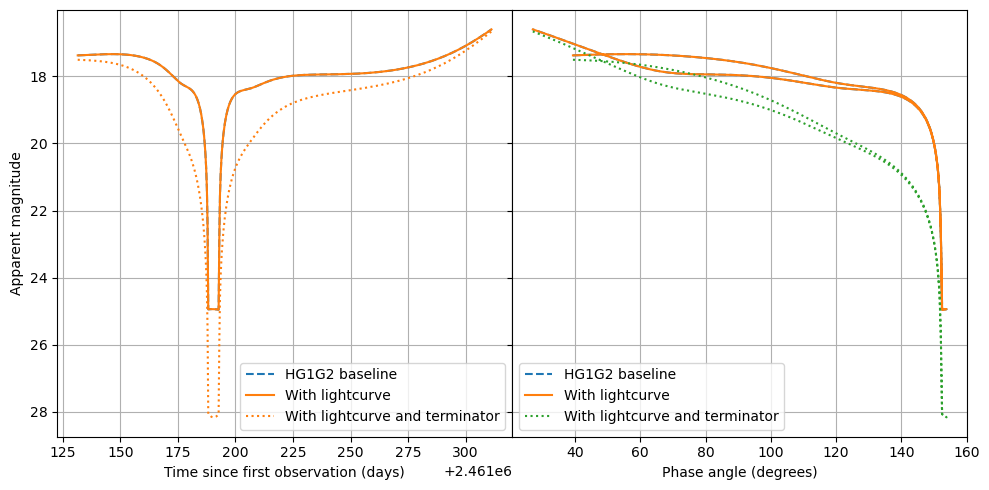

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={"wspace": 0})

# --------------------------------------------------------------------------------
# Apparent magnitude vs time
ax[0].plot(
    observations_df["fieldMJD_TAI"],
    observations_df["HG1G2_mag"],
    linestyle="--",
    color="C0",
    label="HG1G2 baseline",
)
ax[0].plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LC_HG1G2_mag"],
    linestyle="-",
    color="C1",
    label="With lightcurve",
)
ax[0].plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LCwT_HG1G2_mag"],
    linestyle="dotted",
    color="C1",
    label="With lightcurve and terminator",
)

# --------------------------------------------------------------------------------
# Apparent magnitude vs phase
ax[1].plot(
    observations_df["phase_deg"],
    observations_df["HG1G2_mag"],
    linestyle="--",
    color="C0",
    label="HG1G2 baseline",
)
ax[1].plot(
    observations_df["phase_deg"],
    observations_df["LC_HG1G2_mag"],
    linestyle="-",
    color="C1",
    label="With lightcurve",
)
ax[1].plot(
    observations_df["phase_deg"],
    observations_df["LCwT_HG1G2_mag"],
    linestyle="dotted",
    color="C2",
    label="With lightcurve and terminator",
)

# --------------------------------------------------------------------------------
# Axes
for a in ax:
    a.legend()
    a.grid()
ax[0].set_xlabel("Time since first observation (days)")
ax[1].set_xlabel("Phase angle (degrees)")
ax[0].set_ylabel("Apparent magnitude")
ax[0].invert_yaxis()

fig.tight_layout()
fig.savefig("ellipsoidalwithterminator_lightcurve_example.png", dpi=300)

The differences between the two models (``Ellispoidal`` and ``EllipsoidalWithTerminator``) are small, as expected.

Let's illustrated the dependence on phase angle and aspect angle

In [ ]:
from sorcha_addons.lightcurve import ellipsoidalwithterminator_lightcurve

# Compute the aspect angle (degrees)
Lambda = np.degrees(
    np.arccos(
        ellipsoidalwithterminator_lightcurve.cos_aspect_angle(
            np.radians(observations_df.RA_deg),
            np.radians(observations_df.Dec_deg),
            observations_df.Dec0,
            observations_df.RA0,
        )
    )
)

Text(0, 0.5, '$\\Delta$ (with - without terminator)')

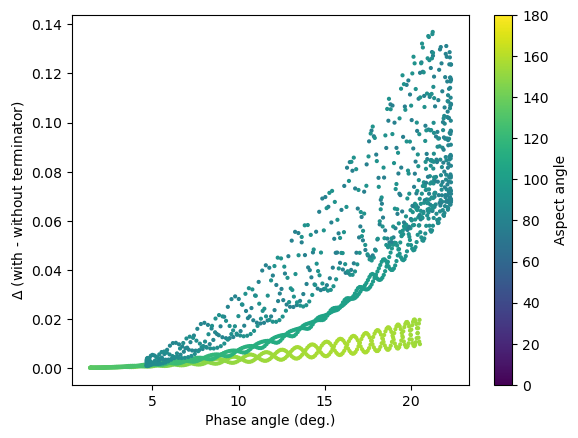

In [ ]:
fig, ax = plt.subplots()

# --------------------------------------------------------------------------------
# Plot the difference between lightcurve with and without terminator
im = ax.scatter(
    observations_df["phase_deg"],
    observations_df["LCwT_HG1G2_mag"] - observations_df["LC_HG1G2_mag"],
    linestyle="-",
    c=Lambda,
    s=4,
    vmin=0,
    vmax=180,
)

# --------------------------------------------------------------------------------
# Axes
fig.colorbar(im, label="Aspect angle")
ax.set_xlabel("Phase angle (deg.)")
ax.set_ylabel(r"$\Delta$ (with - without terminator)")

The difference between the two models is larger at larger phase angles, as expected.
It is also larger for equatorial views, when the apparent shape varies the most.

## Effect of terminator: high phase angles

To understand better the difference between ``Ellipsoidal`` and ``EllipsoidalWithTerminator``, let's generate a ``SORCHA`` lightcurve for an asteroid that reach very high phase angle, (594913) 'Aylo'chaxnim. We will set its shape to a perfect sphere to see the effect of the terminator only (i.e., all paraemters are going to be arbitrary). 

In [ ]:
# Target
sso = 594913
H = 16.2
ra0 = 180.0
dec0 = 0.0
period = 1.0
G1 = 0.62
G2 = 0.14
a_b = 1.0
a_c = 1.0

In [18]:
# Choice of time frame
jd0 = 2461131.5  # Start date: here set to 2026-04-01
nbd = 600  # Number of epochs
step = 0.3  # Time step between epochs (days)

# Generate ephemerides
eph = ephemcc(
    sso,
    ep=jd0,
    nbd=nbd,
    step=step,
    tcoor=5,
    observer="X05",
    output="-- iofile(ephemcc-photom.xml),--lighttime",
)

In [ ]:
# Build the observations dataframe
observations_df = pd.DataFrame(
    {
        "fieldMJD_TAI": eph.Date.values,
        "H_filter": H * np.ones(nbd),
        "G1": G1 * np.ones(nbd),
        "G2": G2 * np.ones(nbd),
        "RA_deg": eph.RA.values,
        "Dec_deg": eph.DEC.values,
        "RA_s_deg": eph.RA_h.values,
        "Dec_s_deg": eph.DEC_h.values,
        "Period": period * np.ones(nbd),
        "Time0": jd0 * np.ones(nbd),
        "phi0": np.radians(0) * np.ones(nbd),
        "RA0": np.radians(ra0) * np.ones(nbd),
        "Dec0": np.radians(dec0) * np.ones(nbd),
        "Period": period * np.ones(nbd),
        "a/b": a_b * np.ones(nbd),
        "a/c": a_c * np.ones(nbd),
        "Range_LTC_km": eph.Dobs.values * au,
        "Obj_Sun_LTC_km": eph.Dhelio.values * au,
        "phase_deg": eph.Phase.values,
    }
)

# Compute magnitude: base, ellipsoidal, ellipsoidal with terminator
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "HG1G2", "r", "HG1G2_mag")

observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG1G2", "r", "LC_HG1G2_mag", "ellipsoidal"
)

observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG1G2", "r", "LCwT_HG1G2_mag", "ellipsoidalwithterminator"
)

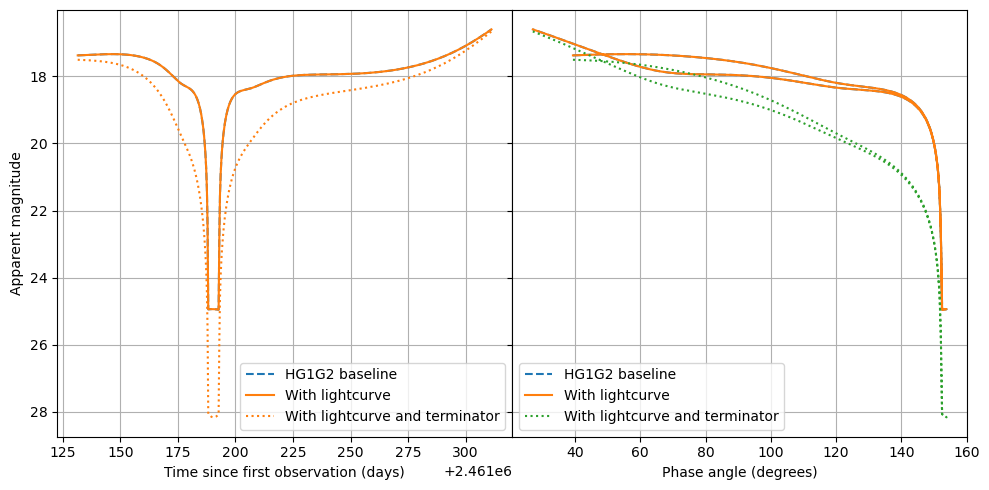

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={"wspace": 0})

# --------------------------------------------------------------------------------
# Apparent magnitude vs time
ax[0].plot(
    observations_df["fieldMJD_TAI"],
    observations_df["HG1G2_mag"],
    linestyle="--",
    color="C0",
    label="HG1G2 baseline",
)
ax[0].plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LC_HG1G2_mag"],
    linestyle="-",
    color="C1",
    label="With lightcurve",
)
ax[0].plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LCwT_HG1G2_mag"],
    linestyle="dotted",
    color="C1",
    label="With lightcurve and terminator",
)

# --------------------------------------------------------------------------------
# Apparent magnitude vs phase
ax[1].plot(
    observations_df["phase_deg"],
    observations_df["HG1G2_mag"],
    linestyle="--",
    color="C0",
    label="HG1G2 baseline",
)
ax[1].plot(
    observations_df["phase_deg"],
    observations_df["LC_HG1G2_mag"],
    linestyle="-",
    color="C1",
    label="With lightcurve",
)
ax[1].plot(
    observations_df["phase_deg"],
    observations_df["LCwT_HG1G2_mag"],
    linestyle="dotted",
    color="C2",
    label="With lightcurve and terminator",
)

# --------------------------------------------------------------------------------
# Axes
for a in ax:
    a.legend()
    a.grid()
ax[0].set_xlabel("Time since first observation (days)")
ax[1].set_xlabel("Phase angle (degrees)")
ax[0].set_ylabel("Apparent magnitude")
ax[0].invert_yaxis()

fig.tight_layout()

The ``Ellipsoidal`` model here above is strictly equal to the HG1G2 solution, because we forced the shape to be a sphere.
The ``EllipsoidalWithTerminator`` solution, however, strongly diverges as the phase angle increases because the fraction of illuminated surface decreases.

Let's finally see this difference between the two ``Ellispoidal`` models:

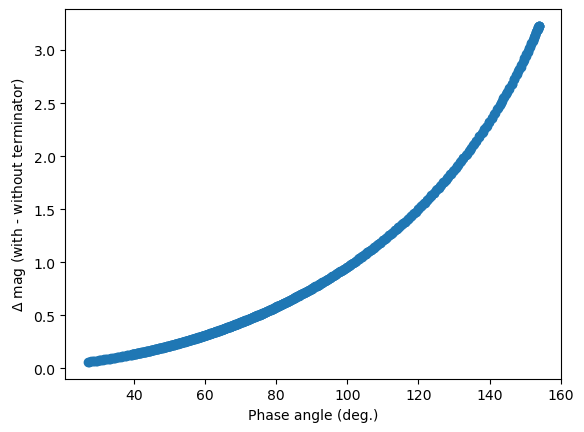

In [ ]:
fig, ax = plt.subplots()

# Plot the difference between lightcurve with and without terminator
ax.scatter(
    observations_df["phase_deg"],
    observations_df["LCwT_HG1G2_mag"] - observations_df["LC_HG1G2_mag"],
    linestyle="-",
)

# Axes
ax.set_xlabel("Phase angle (deg.)")
ax.set_ylabel(r"$\Delta$ mag (with - without terminator)")